In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-online-fake-news-classification/sample_submission.csv
/kaggle/input/hackathon-online-fake-news-classification/train.csv
/kaggle/input/hackathon-online-fake-news-classification/test.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import gc

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib
from transformers import AutoTokenizer, TFBertModel

SEED = 42

In [2]:
df = pd.read_csv("/kaggle/input/hackathon-online-fake-news-classification/train.csv")
df

,id,text,language,label
0,GZsDkNhz42u4SAzbAnUouC,"Last month, Mr. McLaren delivered a preliminar...",english,Real
1,jaRxYZgqXRNrxZiPiLT6xy,JOHANNESBURG (Reuters) - Leaders of Zimbabwe s...,english,Real
2,nYUyyPh5R5zxs8dPa4p6XY,“But our real goal is to reach the stage when ...,english,Real
3,myF2ZaAj2ekwKxuoN8fprG,BEN CARSON fearlessly explain the TRUTH behind...,english,Fake
4,DUQVYqAz4W6EZBy2CFevZq,They just spent big bucks on a new headquarter...,english,Fake
...,...,...,...,...
42445,T2TAxsd3ZX76QPCiCYk45S,Shawn Helton ศตวรรษที่ 21 Wireanother Active-S...,thai,Fake
42446,AEyZjphKDHLfrxbuzJDUMU,"“If we just impose a tariff, they’ll put recip...",english,Real
42447,A7XDwhEUCDctCcTmWXiq7w,"At a blistering speech in Columbus, Ohio (a ve...",english,Fake
42448,Q579MHsdizW54cN5fNBy22,JOHANNESBURG (Reuters) - South Africa s ruling...,english,Real


In [7]:
df['label'] = pd.factorize(df['label'])[0]

In [8]:
X = df['text']
y = df['label']

In [9]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

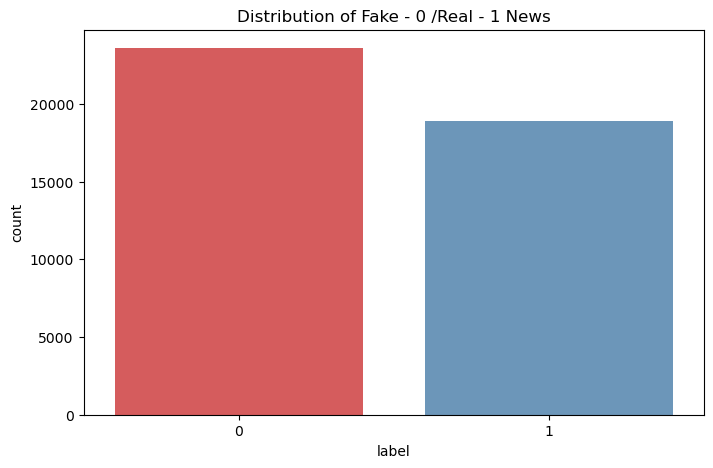

In [10]:
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

In [11]:
#define the LSTM model
MAX_LEN = 100

# def get_model():
#     tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#     bert = TFBertModel.from_pretrained('bert-base-uncased')
    
#     model = tf.keras.Sequential([
#         bert.bert,
#         tf.keras.layers.Dense(2, activation='softmax')
#     ])
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#     return model


def get_model():
    dropout_rate = 0.2

    input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')

    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)

    out = Dropout(0.2)(embeddings)
    
    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)

    y = Dense(1,activation = 'sigmoid')(out)
    
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    
    #define optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-02, epsilon=1e-08,decay=0.01,clipnorm=1.0)
    
    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    
    return model

#define tokenization function
def get_tokens(X):
    
    X = tokenizer(
                text = list(X),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = True,
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )
    
    return X

In [12]:
#plot the model architecture
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

model = get_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


In [13]:
#split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [27]:
X_train

1839     To find out if that’s you, watch the following...
1175     And now it has been revealed that in fact he w...
41342    After meeting Syrian president Assad and speak...
16834    Ending local conflicts and curbing the effects...
26888    Perhaps if the clueless masses won t listen to...
                               ...                        
5507     บ้านในเดือนนี้ Airbnb ยอดนิยมดำเนินไปอย่างเต็ม...
42361    The sources said that a provincial-level  Wuka...
14096    WASHINGTON (Reuters) - Senator Dick Durbin, of...
17043    Conway tried to sell the same tired lines she ...
32361    “This [bill] would make it effectively that yo...
Name: text, Length: 33960, dtype: object

In [14]:
X_train_seq = get_tokens(X_train)
X_test_seq = get_tokens(X_test)

In [ ]:
history = model.fit(x = {'input_ids':X_train_seq['input_ids'],'input_mask':X_train_seq['attention_mask']}, 
                    y = y_train, epochs=10,
                    validation_split = 0.2, batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])


Epoch 1/10
849/849 [==============================] - 353s 416ms/step - loss: 0.1934 - accuracy: 0.9270 - val_loss: 0.2198 - val_accuracy: 0.9152
Epoch 2/10
246/849 [=======>......................] - ETA: 3:41 - loss: 0.1891 - accuracy: 0.9271

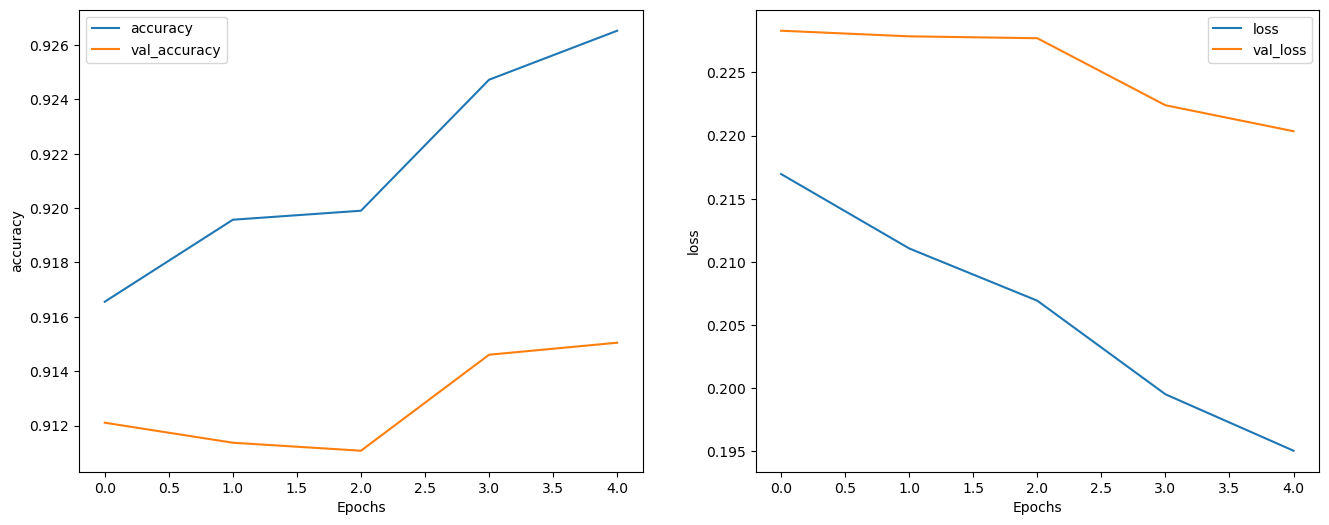

In [20]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [21]:
#predict the test set labels
yhat =  np.where(model.predict({'input_ids':X_test_seq['input_ids'],'input_mask':X_test_seq['attention_mask']}) >=0.5,1,0)

266/266 [==============================] - 37s 138ms/step


In [18]:
## print classification report
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4717
           1       0.93      0.86      0.89      3773

    accuracy                           0.91      8490
   macro avg       0.91      0.90      0.90      8490
weighted avg       0.91      0.91      0.91      8490



Text(70.72222222222221, 0.5, 'Real Labels')

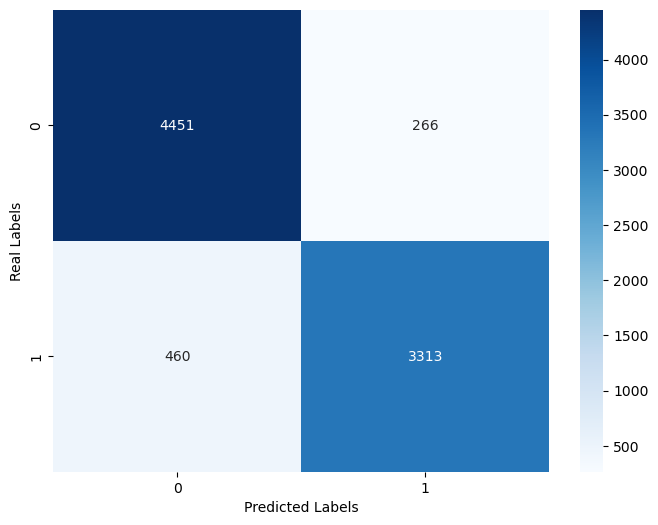

In [22]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [23]:
#save the model 
model.save('fake_news_bert.h5')
model.save_weights("fake_news_bert_weights")

In [25]:
df_test = pd.read_csv("/kaggle/input/hackathon-online-fake-news-classification/test.csv")
df_submission = pd.read_csv("/kaggle/input/hackathon-online-fake-news-classification/sample_submission.csv")

In [28]:
df_test['num_words'] = df_test['text'].apply(lambda x: len(x.split()))
X_test_submission = get_tokens(df_test.text)
len(X_test_submission)

2

In [31]:
#predict the test set labels
p_test =  np.where(model.predict({'input_ids':X_test_submission['input_ids'],'input_mask':X_test_submission['attention_mask']}) >=0.5,1,0)

654/654 [==============================] - 88s 134ms/step


In [45]:
p_test

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [46]:
data_dict = {0:'Real',
             1:'Fake'}

In [47]:
for idx,row in df_test.iterrows():
    if idx > 2:
        df_submission["label"][idx] = data_dict[p_test[idx][0]]
    if idx % 100 == 0:
        print(idx)

df_submission.to_csv('Submission.csv',encoding='utf-8-sig',index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18